# Tutorial 1: Setting up a turbine run
## Using python interface of `amrwind_frontend`

This tutorial shows how the python interface to `amrwind_frontend` can be used to used to accomplish the same actions as the GUI interface demonstrated in [tutorial1](tutorial1gui.md).

For the jupyter notebook version of this tutorial, see [tutorial1_python.ipynb](tutorial1_python.ipynb).  In fact, this markdown was created using the command
```bash
jupyter nbconvert --to markdown tutorial1_python.ipynb
```

**Contents**  

[[_TOC_]]


## Initialization
First the `amrwind_frontend` needs to be loaded, along with some other libraries.  Note that `amrwindfedir` should be set to wherever `amrwind_frontend` was downloaded and installed.

In [1]:
%%capture 

# Important header information
amrwindfedir = '/projects/wind_uq/lcheung/amrwind-frontend'
import sys, os
sys.path.insert(1, amrwindfedir)

# Load the libraries
import matplotlib.pyplot    as plt
import amrwind_frontend as amrwind

# Also ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Make all plots inline 
%matplotlib inline

Now the working directory needs to be created where the necessary input files and turbine files will be stored. 

In [2]:
# Create the working directory and switch to it
workingdir='tutorial1run'
try:
    os.mkdir(workingdir)
except:
    pass
os.chdir(workingdir)

To create an instance of the `amrwind_frontend` app that works without the GUI, instantiate `MyApp` with the `init_nogui()` method:

In [3]:
# Start the amrwind_frontend app 
tutorial1 = amrwind.MyApp.init_nogui()

## Adding inputs

There are two ways to set AMR-Wind parameters using the python interface.  The first is text based, using the `loadAMRWindInput()` interface.  This can be used by defining a string with the AMR-Wind input, written as it would be in a standard input file, and then loading it in:
```python
inputstr="""
time.stop_time                           = 100.0               # Max (simulated) time to evolve
time.max_step                            = -1                  
time.fixed_dt                            = 0.1                 
"""
# Load the input into the app
tutorial1.loadAMRWindInput(inputstr, string=True)
```

The `loadAMRWindInput()` interface can also be used to load an entire input file, simply by providing the filename and making sure `string=False` (or removed from the call):
```python
tutorial1.loadAMRWindInput(filename)
```

However, this way does not maximize the full potential of the python interface.  The second method of input uses the `setAMRWindInput(parametername, value)` interface.  The argument `parametername` can be either the AMR-Wind parameter name, or an internal `amrwind_frontend` parameter (more on this later).  We'll demonstrate this method later on.

### Set the simulation type and properties

We'll first set some basic properties of the simulation, like the simulation time and some time marching properties:

In [4]:
tutorial1.setAMRWindInput('time_control',['const dt'])
tutorial1.setAMRWindInput('time.stop_time',100)
tutorial1.setAMRWindInput('time.fixed_dt', 0.1)
tutorial1.setAMRWindInput('incflo.physics', ['FreeStream', 'Actuator'])

Note that the values of any of these inputs can be queried through the `getAMRWindInput()` command:

In [5]:
# Get the current value of time.stop_time
print(tutorial1.getAMRWindInput('time.stop_time'))

100.0


Now we'll set some other fluid properties and velocities:

In [6]:
tutorial1.setAMRWindInput('ConstValue.density.value',  1.0)
tutorial1.setAMRWindInput('ConstValue.velocity.value', [10.0,0.0,0.0])
tutorial1.setAMRWindInput('turbulence.model',  ['Laminar'])

### Set the domain and boundary conditions

The domain sizes and mesh counts can be set similarly:

In [7]:
tutorial1.setAMRWindInput('geometry.prob_lo', [-1000, -500, -500])
tutorial1.setAMRWindInput('geometry.prob_hi', [ 1000,  500,  500])
tutorial1.setAMRWindInput('amr.n_cell',       [ 128, 64, 64])

To set the Y and Z sides of the domain to be periodic (and X not periodic), use

In [8]:
tutorial1.setAMRWindInput('is_periodicx', False)
tutorial1.setAMRWindInput('is_periodicy', True)
tutorial1.setAMRWindInput('is_periodicz', True)

Note that for the periodicity settings, we're not using the `geometry.is_periodic` parameter.  Instead, we use the `amrwind_frontend` internal parameters called `is_periodicx`, `is_periodicy`, and `is_periodicz`, which are booleans.

The x inflow and x outflow boundary conditions can be applied as normal:

In [9]:
tutorial1.setAMRWindInput('xlo.type', 'mass_inflow')
tutorial1.setAMRWindInput('xhi.type', 'pressure_outflow')
tutorial1.setAMRWindInput('xlo.density', 1.0)
tutorial1.setAMRWindInput('xlo.velocity', [10.0, 0.0, 0.0])

Finally the wind speed through the domain can be set through

In [10]:
tutorial1.setAMRWindInput('incflo.velocity', [10.0, 0.0, 0.0])

### Plot the domain

We can now see what the domain and wind direction look like by creating a plot of it.  To do this, we use the `plotDomain()` command.  Note that the `ax` axes parameter should be set, otherwise it tries to open up the GUI window to make the plot.

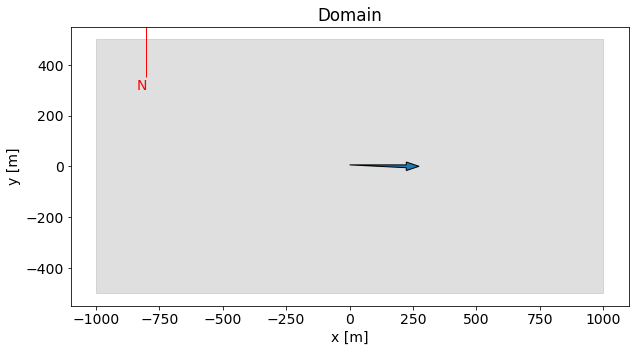

In [11]:
# Plot the domain
plt.rc('font', size=14)
fig, ax = plt.subplots(figsize=(10,10), facecolor='w')
tutorial1.plotDomain(ax=ax)

### Adding a turbine

To add a working turbine to the simulation, we first must include the `AcuatorForcing` term to the `ICNS.source_terms` parameter:

In [12]:
tutorial1.setAMRWindInput('ICNS.source_terms', ['ActuatorForcing'])

The way the turbines get added is by defining a dictionary which contains all necessary properties for the turbine.  Here we'll get the default dictionary, then start modifying properties about it.

In [13]:
# Get a copy the default dictionary which defines AMR-Wind turbines
turbine = tutorial1.get_default_actuatordict()

# Set some basic properties of the turbine, like the name and position
turbine['Actuator_name']          = 'turbine0'
turbine['Actuator_base_position'] = [0, 0, -90]
turbine['Actuator_yaw']           = 270.0
turbine['Actuator_density']       = 1.0

# Print out the dictionary
for k, g in turbine.items(): print('%s: %s'%(k, repr(g)))

Actuator_name: 'turbine0'
use_turbine_type: ''
copy_turb_files: 1
edit_fast_files: 1
Actuator_type: None
Actuator_openfast_input_file: None
Actuator_base_position: [0, 0, -90]
Actuator_rotor_diameter: None
Actuator_hub_height: None
Actuator_num_points_blade: None
Actuator_num_points_tower: None
Actuator_epsilon: None
Actuator_epsilon_tower: None
Actuator_openfast_start_time: None
Actuator_openfast_stop_time: None
Actuator_nacelle_drag_coeff: None
Actuator_nacelle_area: None
Actuator_yaw: 270.0
Actuator_output_frequency: None
Actuator_density: 1.0


However, there are still a lot of properties which are undefined for the turbine.  Rather than specifying each one individually, we can copy over the parameters from one of the previously defined turbines.  In this case, we'll use the `NREL5MW ADM NOSERVO` turbine.  This can be done with the `turbinemodels_applyturbinemodel()` function.

Note that both the `docopy` and `updatefast` parameters are set to `True`.  `docopy` creates a copy of the necessary OpenFAST files needed to run the turbine, and puts it into a new directory based on the turbine name.  `updatefast` will modify any `OpenFAST` files so that the settings in `OpenFAST` are consistent with `AMR-Wind`.

Finally, the turbine is added to the simulation with `add_turbine()`.

In [14]:
turbine = tutorial1.turbinemodels_applyturbinemodel(turbine, 'NREL5MW ADM NOSERVO', docopy=True, updatefast=True)

# Add the turbine to the simulation.
tutorial1.add_turbine(turbine, verbose=True)

docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL5MW to turbine0_OpenFAST_NREL5MW
turbine0_OpenFAST_NREL5MW/nrel5mw_noservo.fst
/gpfs1/lcheung/TCF/TurbineCheckout/test/tutorial1run/turbine0_OpenFAST_NREL5MW/./5MW_Baseline/NRELOffshrBsline5MW_Onshore_AeroDyn15.dat
Actuator_name: 'turbine0'
use_turbine_type: ''
copy_turb_files: 1
edit_fast_files: 1
Actuator_type: 'TurbineFastDisk'
Actuator_openfast_input_file: 'turbine0_OpenFAST_NREL5MW/nrel5mw_noservo.fst'
Actuator_base_position: [0, 0, -90]
Actuator_rotor_diameter: 126.0
Actuator_hub_height: 90.0
Actuator_num_points_blade: 64
Actuator_num_points_tower: 12
Actuator_epsilon: [10.0, 10.0, 10.0]
Actuator_epsilon_tower: [5.0, 5.0, 5.0]
Actuator_openfast_start_time: 0.0
Actuator_openfast_stop_time: 1000.0
Actuator_nacelle_drag_coeff: 0.0
Actuator_nacelle_area: 0.0
Actuator_yaw: 270.0
Actuator_output_frequency: 10
Actuator_density: 1.0


       1.0 AirDens - Air density (kg/m^3) [EDITED]


### Adding a refinement window

Refinement windows can be added in a similar fashion as turbines.  First we'll set `AMR-Wind` to use 1 level of refinement.

In [15]:
tutorial1.setAMRWindInput('amr.max_level', 1)

Then we'll get the default dictionary for refinement windows, and modify it to suit our purposes.  In this example, we're creating a box refinement zone with specified coordinates.  Finally, we'll add it to the simulation with the `add_tagging()` function.

In [16]:
# Get the default dictionary for refinement window
refinewin = tutorial1.get_default_taggingdict()

# Edit the parameters of the refinement window
refinewin['tagging_name']         = 'box1'
refinewin['tagging_shapes']       = 'box1'
refinewin['tagging_type']         = 'GeometryRefinement'
refinewin['tagging_level']        = 0
refinewin['tagging_geom_type']    = 'box'
refinewin['tagging_geom_origin']  = [-200, -200, -200]
refinewin['tagging_geom_xaxis']   = [400, 0, 0]
refinewin['tagging_geom_yaxis']   = [0, 400, 0]
refinewin['tagging_geom_zaxis']   = [0, 0, 400]

# Add refinement zone to simulation.
tutorial1.add_tagging(refinewin)

### Adding a sampling plane

We'll follow the same process for adding in a sampling plane.  First, we need to tell AMR-Wind to add sampling functionality to the simulation and tell it to sample velocity fields every 100 iterations:

In [17]:
tutorial1.setAMRWindInput('incflo.post_processing',    ['sampling'])
tutorial1.setAMRWindInput('sampling.output_frequency', 100)
tutorial1.setAMRWindInput('sampling.fields',           ['velocity'])

Now we'll create the sampling plane by getting a default sampling probe dictionary and then modifying it.  In this case, we're creating a single sampling plane at hub-height, with specified origin and dimensions.

In [18]:
# Get the default dictionary for sampling probes
sampleplane = tutorial1.get_default_samplingdict()

# Modify the geometry
sampleplane['sampling_name'] = 'xyplane'
sampleplane['sampling_type'] = 'PlaneSampler'
sampleplane['sampling_p_num_points'] = [101, 51]
sampleplane['sampling_p_origin']     = [-1000, -500, 0]
sampleplane['sampling_p_axis1']      = [2000, 0, 0]
sampleplane['sampling_p_axis2']      = [0, 1000, 0]

# Add sampling plane to simuation
tutorial1.add_sampling(sampleplane, verbose=True)

default_alwaysfalse: False
sampling_name: 'xyplane'
sampling_type: 'PlaneSampler'
sampling_pf_probe_location_file: None
sampling_l_num_points: 2
line_probe_xyzheader: ['X', 'Y', 'Z']
sampling_l_start: [0, 0, 0]
sampling_l_end: [1, 1, 1]
sampling_p_num_points: [101, 51]
sample_plane_xyzheader: ['X', 'Y', 'Z']
sampling_p_origin: [-1000, -500, 0]
sampling_p_axis1: [2000, 0, 0]
sampling_p_axis2: [0, 1000, 0]
sampling_p_normal: [0, 0, 0]
sampling_p_offsets: None


### Plotting the domain again

We can now re-plot the domain, but this time include the turbine, refinement window, and sampling plane.  Again, we'll use the `plotDomain()` function, but this time we'll add the additional features to plot through the `popup_storteddata['plotdomain']` option:

Plotting turbines


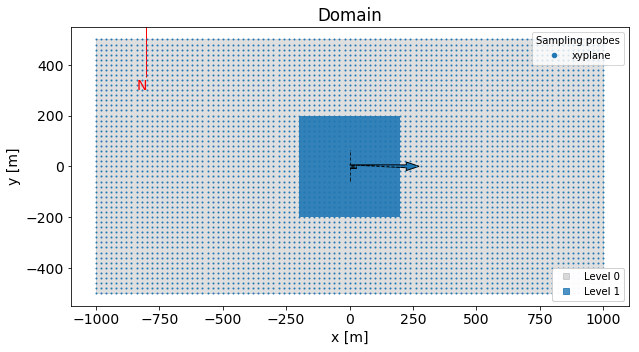

In [19]:
# Create a figure and axes to plot domain
plt.rc('font', size=14)
fig, ax = plt.subplots(figsize=(10,10), facecolor='w')

# Set additional items to plot
tutorial1.popup_storteddata['plotdomain']['plot_sampleprobes']    = ['xyplane']
tutorial1.popup_storteddata['plotdomain']['plot_turbines']        = ['turbine0']
tutorial1.popup_storteddata['plotdomain']['plot_refineboxes']     = ['box1']

# Plot the figure 
tutorial1.plotDomain(ax=ax)

### Validating inputs

Before running this case, we can check that the inputs have been set up correctly.  Use the `validate()` function, and hopefully the output shows that all things passed, with no failures or warnings.

In [20]:
# Validate the inputs
checkoutput=tutorial1.validate()

-- Checking inputs --
[ PASS] max_level:           max_level = 1 >= 0
[ PASS] Actuator physics:    incflo.physics and ICNS.source_terms OK for Actuators
[ PASS] Actuator FST:turbine0 [turbine0_OpenFAST_NREL5MW/nrel5mw_noservo.fst] exists
[ PASS] Actuator FST:turbine0 CompInflow OK
[ PASS] Actuator FST:turbine0 [turbine0_OpenFAST_NREL5MW/./5MW_Baseline/NRELOffshrBsline5MW_Onshore_AeroDyn15.dat] exists
[ PASS] Actuator FST:turbine0 WakeMod=0 OK
[ PASS] Actuator FST:turbine0 AirDens=1.000000, matches incflo.density=1.000000
[ PASS] Sampling probes:xyplane 

Results: 
 8 PASS
 0 SKIP
 0 FAIL
 0 WARN


### Saving the input file

Finally, all of these parameters can be saved into an input file through the `writeAMRWindInput()` function.  However, first we'll take a look at what the input file will look like by passing in the null string `''` and printing it to the screen:

In [21]:
outstr=tutorial1.writeAMRWindInput('')
print(outstr)

# --- Simulation time control parameters ---
time.stop_time                           = 100.0               # Max (simulated) time to evolve [s]
time.max_step                            = -1                  
time.fixed_dt                            = 0.1                 # Fixed timestep size (in seconds). If negative, then time.cfl is used
incflo.physics                           = FreeStream Actuator # List of physics models to include in simulation.
incflo.verbose                           = 0                   
io.check_file                            = chk                 
incflo.use_godunov                       = true                
incflo.godunov_type                      = ppm                 
turbulence.model                         = Laminar             
incflo.gravity                           = 0.0 0.0 -9.81       # Gravitational acceleration vector (x,y,z) [m/s^2]
incflo.density                           = 1.0                 # Fluid density [kg/m^3]
transport.viscosity 

Then we'll actually write it to a file by specifying the filename `tutorial1.inp` (this can be anything):

In [22]:
outstr=tutorial1.writeAMRWindInput('tutorial1.inp')

That's it!  Now we are ready to run the case.

## Submitting the job
We can also have `amrwind_frontend` create a submission script and submit it to the queue.  To do this, edit the `submitscript` dictionary like this:

In [23]:
# Set some of the submission script parameters
tutorial1.popup_storteddata['submitscript']['submitscript_filename'] = 'submit.sh'
tutorial1.popup_storteddata['submitscript']['submitscript_jobname']  = 'amrwind_test1'
tutorial1.popup_storteddata['submitscript']['submitscript_numnodes'] = 2
tutorial1.popup_storteddata['submitscript']['submitscript_runtime']  = '1:00:00'
tutorial1.popup_storteddata['submitscript']['submitscript_wcid']     = 'FY190020'

To print out what the submission script would look like use `submitscript_makescript()`.  Note that the argument is the AMR-Wind input filename (`savefile` is the filename that was set in `writeAMRWindInput()` above).

In [ ]:
# Preview what the submission script looks like
print(tutorial1.submitscript_makescript(tutorial1.savefile))

To save the job, use `submitscript_savescript()`.  Add the keyword `submit=True` to actually submit the job to the queue:

In [24]:
tutorial1.submitscript_savescript(submit=True)

Saved submit.sh
Executing: sbatch submit.sh
sbatch: INFO: Adding filesystem licenses to job: gpfs1:1,nscratch:1,pscratch:1
Submitted batch job 24558098



## Postprocessing
### Plotting the FAST outputs

First, let's load the FAST output file and see what data is in there.

In [25]:
# Load the FAST output file
headers=tutorial1.FAST_loadallfiles(None, outfile='turbine0_OpenFAST_NREL5MW/nrel5mw_noservo.out')

Loading turbine0_OpenFAST_NREL5MW/nrel5mw_noservo.out


There's a lot of variables we could plot in that file, let's take a look at the first 10:

In [26]:
print(headers[:10])

['Time', 'Wind1VelX', 'Wind1VelY', 'Wind1VelZ', 'OoPDefl1', 'IPDefl1', 'TwstDefl1', 'BldPitch1', 'Azimuth', 'RotSpeed']


Let's choose to plot the `Wind1VelX` variable

In [27]:
tutorial1.popup_storteddata['plotfastout']['plotfastout_vars']     = ['Wind1VelX']

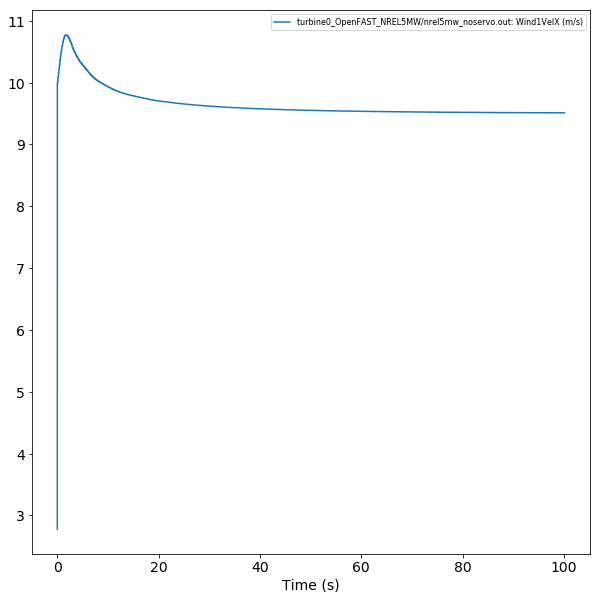

In [28]:
# Create a plot and plot it.
plt.rc('font', size=14)
fig, ax = plt.subplots(figsize=(10,10), facecolor='w')
tutorial1.FAST_plotoutputs(ax=ax)

### Plotting the sample plane
After the job is completed, we can also examine the flow fields through the python interface

In [29]:
tutorial1.Samplepostpro_loadnetcdffile('post_processing/sampling00000.nc')

Loading post_processing/sampling00000.nc


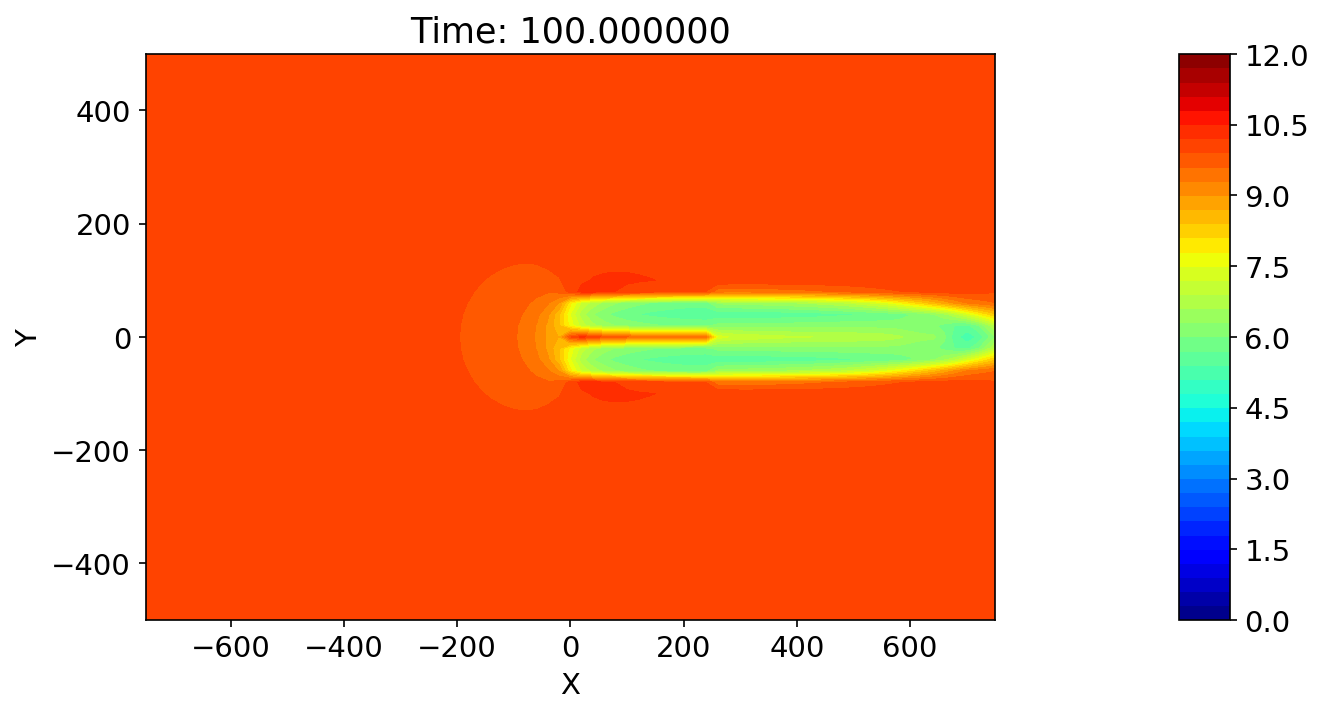

In [30]:
# Load the libraries
import numpy as np
from matplotlib import cm

# Create the figure with 2 subplots (one for image, one for colorbar)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5), gridspec_kw={'width_ratios': [1,  0.05]}, dpi=150)

# Set the plot parameters
levels     = np.linspace(0,12,41)
plotvar    = 'velocityx'  # Plot the velocityx variable
plotindex  = 10           # Plot the 10th step in netcdf file (corresponding to time 100.0)
planei     = 0            # Plot the 0th plane (the only one in this instance)
# Create the image
im1 = tutorial1.plotSamplePlane('xyplane', plotvar, plotindex, planei, 'X','Y',ax=ax1, colorbar=False, 
                                levels=levels, cmap=cm.jet)
fig.colorbar(im1[0], cax=ax2)
ax1.set_xlim([-750, 750]);